
# **Graded Notebook 2025**

#### **Dataset information**
We will use the **Health Insurance Costs** dataset (`insurance.csv`). Each row describes a person's demographic information (age, sex, BMI, number of children, region, smoker status) and the medical charges billed by an insurance company.

Download the dataset here: [insurance.csv](https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv) and save it in the same directory as this notebook.

**Focus:** Scoring prioritizes how well you *interpret* and communicate the results (plots, coefficients, errors, and caveats). Raw accuracy is secondary. Use markdown cells to explain what the numbers mean in plain language.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor




---
## **Task 1: Explore and prepare the data (15 points)**

#### **1.1: Load and inspect (5 points)**
- Load `insurance.csv` and display the head, shape, and data types.
- Identify the meaning of each column and which are categorical vs. numerical, note any immediate quirks you observe (e.g., units, obvious outliers).
- Which column is likely to be your target? Why?


In [2]:
# Task 1.1
insurance_frame = pd.DataFrame(pd.read_csv("insurance.csv"))

print("===> dataset first 5 rows <===\n")
print(insurance_frame.head())

print("\n===> dataset shape <===\n")
print(insurance_frame.shape)

print("\n===> dataset data types <===\n")
print(insurance_frame.dtypes)

print("\n===> dataset description <===\n")
print(insurance_frame.describe())

print("\n==> dataset unique values (by column) <===\n")
print(insurance_frame.nunique())

===> dataset first 5 rows <===

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

===> dataset shape <===

(1338, 7)

===> dataset data types <===

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

===> dataset description <===

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     

# Observations
Categorical columns:
- sex (2 values)
- smoker (2 values)
- region (4 values)

Numerical columns:
- age (lowest is 18, highest 64. Average age is ~39, most people between 25 - 53)
- bmi (lowest is 15,96 (underweight), highest 53,13 (severely obese). Average BMI is 30,66, most people between 24,56 - 36,76)
- children (lowest count is 0, highest is 5. Average count is 1 child / person, most have between 0 - 2)
- charges (lowest charges are 1121,87, highest are 63770,43 (very large range). Average charges are 13270,42, most people have between 0 - 37,490)

Actually, the STD range for charges is between -10,950 - 37,490. Due to there being a huge range in charges, it's causing the lower value to dip into the negative, but that doesn't make any sense in real life. From the numerical columns, charges is a clear outlier due to the large range in values.

From the categorical values region stands out as an outlier. It contains twice as many values as the other two, one for each intermediate direction. It may be worth analysing if different regions have different costs.

## Charges is the best candidate for a target
All the other values are more like predictors, and a prediction of a person's medical costs would be a useful prediction to make for insurance companies.



#### **1.2: Understand distributions and relationships (10 points)**
- Visualize distributions and explore relationships between the features and the target.
- Summarize 2–3 hypotheses about which factors likely drive costs and why.

Plot 1


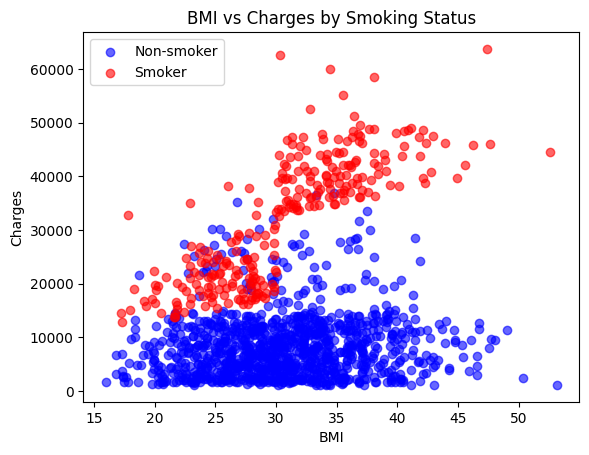

Plot 2


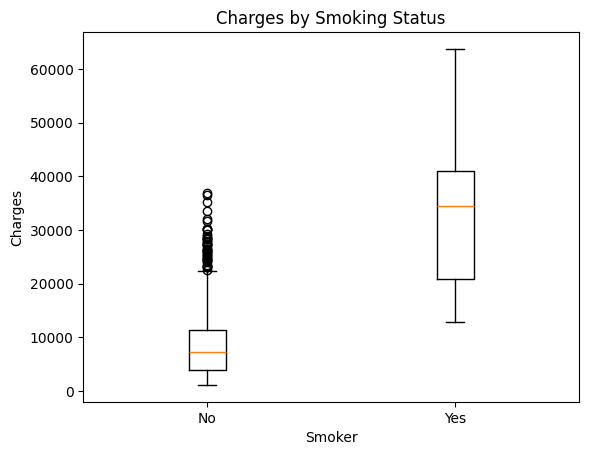

Plot 3


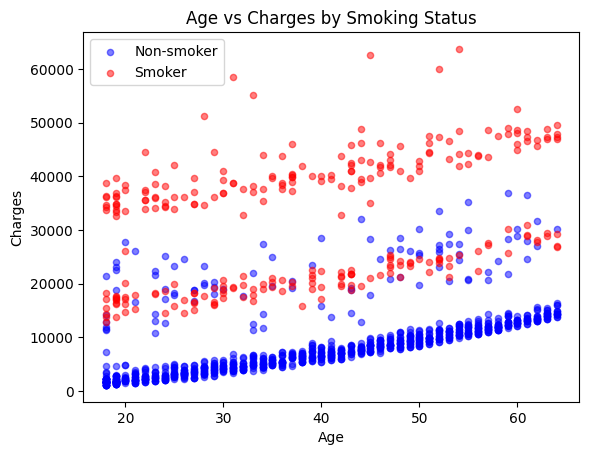

Plot 4


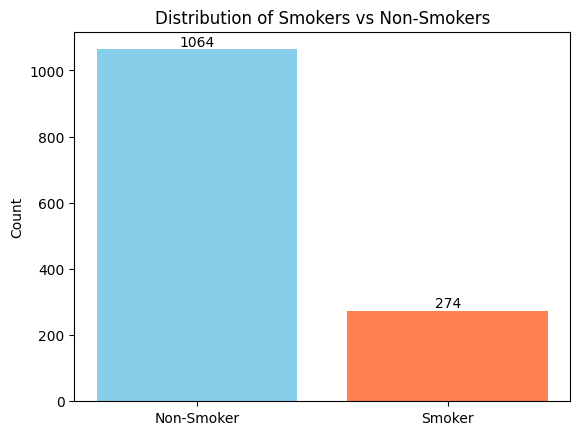

In [3]:
# Task 1.2

print("Plot 1")
# Separate the data into smokers and non-smokers
smokers = insurance_frame[insurance_frame["smoker"] == "yes"]
non_smokers = insurance_frame[insurance_frame["smoker"] == "no"]

# Plot each group with different colors
plt.scatter(non_smokers["bmi"], non_smokers["charges"], 
            alpha=0.6, label="Non-smoker", color="blue")
plt.scatter(smokers["bmi"], smokers["charges"], 
            alpha=0.6, label="Smoker", color="red")

plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("BMI vs Charges by Smoking Status")
plt.legend()
plt.show()

print("Plot 2")
# Box plot for smoker vs charges
smoker_data = [
    insurance_frame[insurance_frame["smoker"] == "no"]["charges"],
    insurance_frame[insurance_frame["smoker"] == "yes"]["charges"]
]

plt.boxplot(smoker_data, tick_labels=["No", "Yes"])
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.title("Charges by Smoking Status")
plt.show()

print("Plot 3")
smokers = insurance_frame[insurance_frame["smoker"] == "yes"]
non_smokers = insurance_frame[insurance_frame["smoker"] == "no"]

plt.scatter(non_smokers["age"], non_smokers["charges"], 
            alpha=0.5, label="Non-smoker", color="blue", s=20)
plt.scatter(smokers["age"], smokers["charges"], 
            alpha=0.5, label="Smoker", color="red", s=20)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Age vs Charges by Smoking Status")
plt.legend()
plt.show()

print("Plot 4")
smoker_counts = insurance_frame["smoker"].value_counts()

bars = plt.bar(["Non-Smoker", "Smoker"], 
               [smoker_counts["no"], smoker_counts["yes"]], 
               color=["skyblue", "coral"])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.ylabel("Count")
plt.title("Distribution of Smokers vs Non-Smokers")
plt.show()

# Observations

## Hypothesis 1: Smokers will have increased medical charges
From plots 1-3 we can clearly see that higher medical charges are directly linked to being a smoker. Most people in the dataset are not smokers, and have medical charges below 15 000. Smokers, on the other hand, do not have medical charges below 10 000. Non-smokers do not typically incur this level of cost until they are >= 50 years old, while smokers can exceed it before they're 20.

Due to the negative effects on a person's health smoking cause, it is not surprising to see it have an effect on medical charges.

## Hypothesis 2: The older you are, the higher your medical charges will be
As we can see from plot 3, as a person's age increases, so too do their medical charges. Each distinct group of peoples' medical charges curve upward as their age increases.

As a person ages, they are more likely to develop more severe illnesses. Cancer, for example, can take decades to develop. This leads to it being more prevalent in older people.

## Hypothesis 3: Higher BMI will lead to increased medical charges
This seems to be true, but it is as not as pronounced of an effect as with the other two predictors, smoking status & age. However as is visible in plot 1, it seems that if a smoker has a higher BMI, it does lead to a stronger effect on incurring higher medical charges.

A higher BMI may be making existing health problems, for example ones causeed by smoking, to be worsened, leading to higher medical charges.

### Three most effective predictors
Smoker, Age, BMI.



---
## **Task 2: Regression – Predict medical charges (30 points)**

#### **2.1: Baseline linear models (15 points)**
- Using the features of your choice (likely linked to your hypothesis above), build a linear regression model to predict your target. Be mindful about the encoding of categorical values.
- Evaluate with at least two metrics and interpret their individual meaning.
- Interpret the sign and relative magnitude of coefficients linked to each feature in the model: what do they suggest about the link between each feature and the target?


In [4]:
# Task 2.1
encoded_insurance = pd.get_dummies(insurance_frame, columns=["sex", "smoker", "region"], drop_first=True)

X = encoded_insurance.drop("charges", axis=1)
y = encoded_insurance["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train,y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


R² Score: 0.7836
RMSE: 5796.28
MAE: 4181.19


From the print outputs, we can see we have an R2 score of ~78%, meaning with the predictors we have, our model explains 78% of variance in charges. Pretty good, but could be better.

Our RMSE tells us on average, our prediction is off by just under 6 000. This is quite a lot, given the fact that the average charges is ~13 000, meaning our RMSE is just under half of the average amount of charges. Could be better.

Finally, our MAE is just over 4 000. In layman's terms, this means the average error of our predictions. It's another averaging metric, but is less sensitive to outliers (we have very high outliers) than RMSE.

# Coefficients

In [5]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})

# Sort by absolute magnitude (biggest impact first)
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(coef_df)
print(f"\nIntercept: {model.intercept_:,.2f}")

            Feature   Coefficient  Abs_Coefficient
4        smoker_yes  23651.128856     23651.128856
7  region_southwest   -809.799354       809.799354
6  region_southeast   -657.864297       657.864297
2          children    425.278784       425.278784
5  region_northwest   -370.677326       370.677326
1               bmi    337.092552       337.092552
0               age    256.975706       256.975706
3          sex_male    -18.591692        18.591692

Intercept: -11,931.22


# Observations

What we can see from the result here is that smoking is **by far** the strongest coefficient. Just being a smoker increases medical charges by nearly 23 700. We can also see BMI and & age being related to higher medical costs, but the amount of children is also increasing medical charges!

Northeast, the region not included in the training data, is the most expensive, with northwest being the second. From this we can conclude that healthcare costs are higher in the northern part of the country than the south.

There is also a very small difference in medical charges by gender, with men paying nearly 19 (whatever currency this is) less in medical charges.


#### **2.2: Improving metrics (15 points)**
- Try improving your results, one can chose one or more of the following methods:
    - Adding or removing some features
    - Transforming some features (e.g. polynomials)
    - Using another regression algorithm
- Are your results better? Why?


In [14]:
# Task 2.2
# doing a random forest because trees are cool

rf_model = RandomForestRegressor(
    n_estimators=100,      # tree number
    max_depth=10,          # tree depth
    min_samples_split=10,  # supposedly controls overfitting
    random_state=42,
    n_jobs=-1              # something about how many cpu cores are being used
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")

feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_imp)

R²: 0.8708
RMSE: $4,479.18
            Feature  Importance
4        smoker_yes    0.649327
1               bmi    0.200544
0               age    0.128430
2          children    0.013545
5  region_northwest    0.002505
6  region_southeast    0.001928
7  region_southwest    0.001872
3          sex_male    0.001848


# Observations

Wow! Much better results!

We now have an R2 score of 87%, that's a 9% increase from the linear regression model.

Additionally, we have a RMSE 1 317 lower than the previous model. That's a decrease of 29.4%!

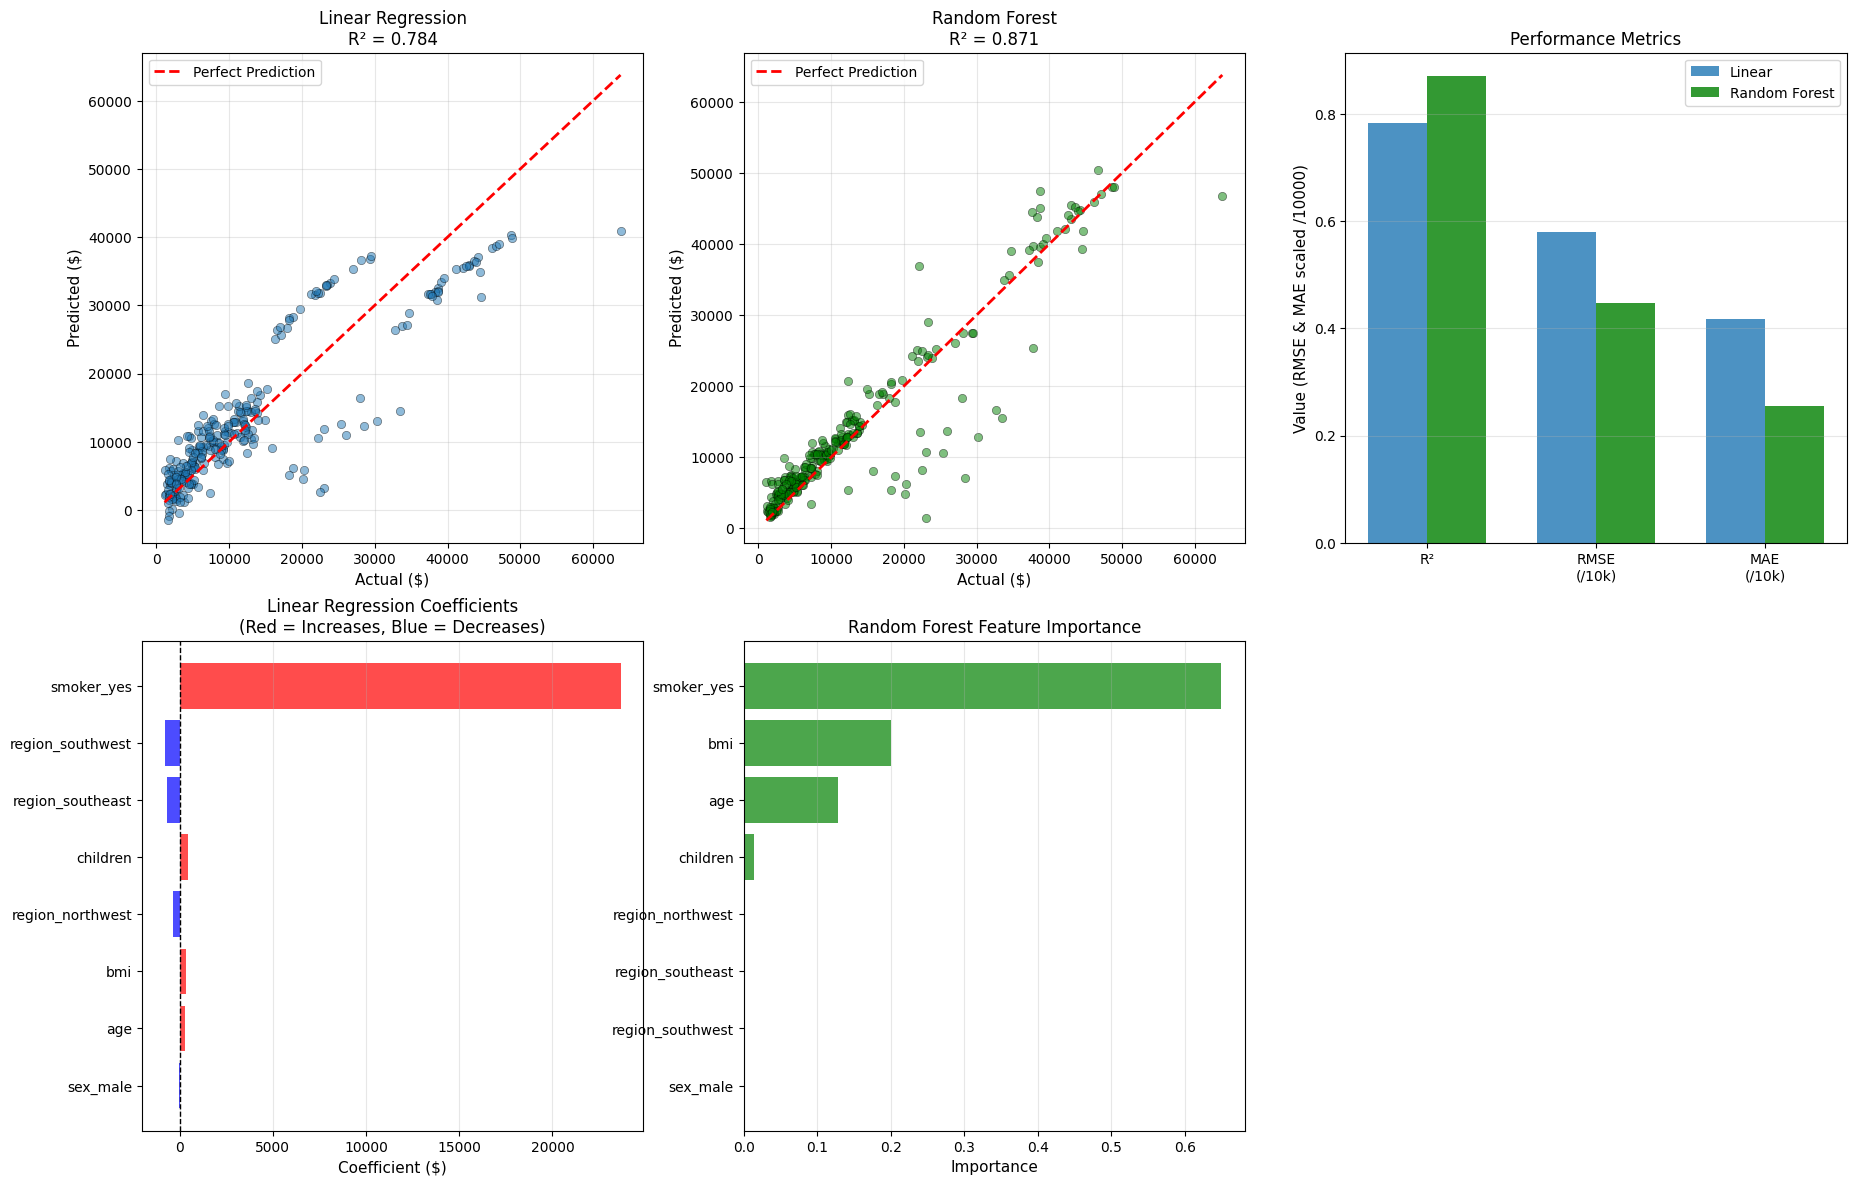

In [25]:
y_pred_lr = model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf

# Create comprehensive figure
fig = plt.figure(figsize=(22, 14))

# 1. Actual vs Predicted - Linear Regression
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_test, y_pred_lr, alpha=0.5, edgecolors='k', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual ($)', fontsize=11)
ax1.set_ylabel('Predicted ($)', fontsize=11)
ax1.set_title(f'Linear Regression\nR² = {r2_score(y_test, y_pred_lr):.3f}', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Actual vs Predicted - Random Forest
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(y_test, y_pred_rf, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual ($)', fontsize=11)
ax2.set_ylabel('Predicted ($)', fontsize=11)
ax2.set_title(f'Random Forest\nR² = {r2_score(y_test, y_pred_rf):.3f}', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Metrics Comparison
ax3 = plt.subplot(2, 3, 3)
metrics = {
    'R²': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), 
             np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), 
            mean_absolute_error(y_test, y_pred_rf)]
}
x = np.arange(len(metrics))
width = 0.35
ax3.bar(x - width/2, [metrics['R²'][0], metrics['RMSE'][0]/10000, metrics['MAE'][0]/10000], 
        width, label='Linear', alpha=0.8)
ax3.bar(x + width/2, [metrics['R²'][1], metrics['RMSE'][1]/10000, metrics['MAE'][1]/10000], 
        width, label='Random Forest', alpha=0.8, color='green')
ax3.set_ylabel('Value (RMSE & MAE scaled /10000)', fontsize=11)
ax3.set_title('Performance Metrics', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(['R²', 'RMSE\n(/10k)', 'MAE\n(/10k)'])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Coefficients - Linear Regression
ax4 = plt.subplot(2, 3, 4)
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=True)
colors = ['red' if x > 0 else 'blue' for x in coef_df['Coefficient']]
ax4.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Coefficient ($)', fontsize=11)
ax4.set_title('Linear Regression Coefficients\n(Red = Increases, Blue = Decreases)', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

# 5. Feature Importance - Random Forest
ax5 = plt.subplot(2, 3, 5)
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)
ax5.barh(feature_imp['Feature'], feature_imp['Importance'], color='green', alpha=0.7)
ax5.set_xlabel('Importance', fontsize=11)
ax5.set_title('Random Forest Feature Importance', fontsize=12)
ax5.grid(True, alpha=0.3, axis='x')


---
## **Task 3: Classification – Identify high-cost patients (30 points)**

#### **3.1: Define a binary outcome (5 points)**
- Create a `high_cost` label using a clear threshold on the charges column. Justify the cutoff and show the class balance.


In [7]:
# Task 3.1


#### **3.2: Features analysis (10 points)**
- Similar to 1.2, explore the relationship between the features and this new target. What can you say?

In [8]:
# Task 3.2



#### **3.3: Train and compare classifiers (15 points)**
- Train at least two different classifiers algorithms with sensible preprocessing.
- Evaluate the results with a set of classifiaction metrics, justify your choices and interpret their meaning.
- Interpret the types of mistakes each model makes and which features drive their decisions.


In [9]:
# Task 3.3



---
## **Task 4: PCA (15 points)**
- Apply a PCA to reduce the number of features. 
- Carefully select the number of PC to use and document this choice.
- Train a model on these new features and iscuss how PCA affects model performances.

In [10]:
# Task 4



---
## **Task 5: Unsupervised insights (10 points)**
- Apply clustering (e.g., K-Means) or another unsupervised method on selected features.
- Visualize and describe the discovered profiles: what characterizes each cluster?


In [11]:
# Task 5



---
## **Bonus: Anything more? (Optional)**
- If you feel like, implement anything that was not covered in this notebook (e.g. another model or task, cross validation, ...)

In [12]:
# Bonus Task
